# Data Exploration for XAI Analysis

**Purpose**: Basic exploratory data analysis for thesis appendix.

This notebook provides descriptive statistics and distributions for:
- Target variable (default rates)
- Feature distributions (histograms, summary statistics)
- Temporal patterns (defaults over time)
- Missing data patterns

**Outputs**: Tables and figures for thesis appendix.

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

PROJ_ROOT = Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.append(str(PROJ_ROOT))

from credit_risk_xai.config import FEATURE_CACHE_PATH, BASE_CACHE_PATH
from credit_risk_xai.features.engineer import prepare_modeling_data

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

print(f"Project root: {PROJ_ROOT}")

Project root: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis


## 1. Load Data

In [5]:
# Load full dataset
df_full = pd.read_parquet(FEATURE_CACHE_PATH)
print(f"Full dataset: {len(df_full):,} observations")
print(f"Columns: {len(df_full.columns)}")
print(f"\nDate range: {df_full['ser_year'].min()} - {df_full['ser_year'].max()}")

Full dataset: 12,415,724 observations
Columns: 76

Date range: 1998 - 2023


In [6]:
# Apply same filters as modeling
df = df_full[
    (df_full["ser_aktiv"] == 1) & 
    (df_full["sme_category"].isin(["Small", "Medium"])) & 
    (df_full["knc_kncfall"] == 1) &
    (df_full["bransch_borsbransch_konv"] != "40.0")
].copy()

print(f"\nFiltered dataset: {len(df):,} observations ({len(df)/len(df_full)*100:.1f}% of full data)")
print(f"Filters applied:")
print(f"  - Active companies (ser_aktiv==1)")
print(f"  - Small & Medium SMEs")
print(f"  - Credit reporting companies (knc_kncfall==1)")
print(f"  - Excluded industry: 40.0 (Financial services)")


Filtered dataset: 326,658 observations (2.6% of full data)
Filters applied:
  - Active companies (ser_aktiv==1)
  - Small & Medium SMEs
  - Credit reporting companies (knc_kncfall==1)
  - Excluded industry: 40.0 (Financial services)


## 2. Target Variable Analysis

In [7]:
# Prepare modeling data
X, y = prepare_modeling_data(df)

print("="*80)
print("TARGET VARIABLE: target_next_year (Default within 12 months)")
print("="*80)
print(f"\nTotal observations: {len(y):,}")
print(f"\nClass distribution:")
print(y.value_counts())
print(f"\nDefault rate: {y.mean()*100:.2f}%")
print(f"Imbalance ratio: {(y==0).sum()/(y==1).sum():.1f}:1")

TARGET VARIABLE: target_next_year (Default within 12 months)

Total observations: 304,149

Class distribution:
target_next_year
0    298795
1      5354
Name: count, dtype: Int64

Default rate: 1.76%
Imbalance ratio: 55.8:1


In [8]:
# Default rate over time
df_with_target = df.copy()
df_with_target['target_next_year'] = y

default_rate_by_year = df_with_target.groupby('ser_year').agg({
    'target_next_year': ['sum', 'count', 'mean']
}).reset_index()
default_rate_by_year.columns = ['ser_year', 'n_defaults', 'n_total', 'default_rate']

print("\nDefault Rate by Year:")
print("="*80)
print(default_rate_by_year.to_string(index=False))


Default Rate by Year:
 ser_year  n_defaults  n_total  default_rate
     1998         191    10467      0.018248
     1999         171    10974      0.015582
     2000         269    11293       0.02382
     2001         285    11450      0.024891
     2002         277    11411      0.024275
     2003         234    11086      0.021108
     2004         165    10915      0.015117
     2005         142    11021      0.012884
     2006         136    11531      0.011794
     2007         286    12374      0.023113
     2008         298    12359      0.024112
     2009         196    11841      0.016553
     2010         199    12026      0.016547
     2011         220    12179      0.018064
     2012         226    11986      0.018855
     2013         212    11801      0.017965
     2014         158    11704        0.0135
     2015         172    12003       0.01433
     2016         216    12422      0.017389
     2017         229    12531      0.018275
     2018         238    12684  

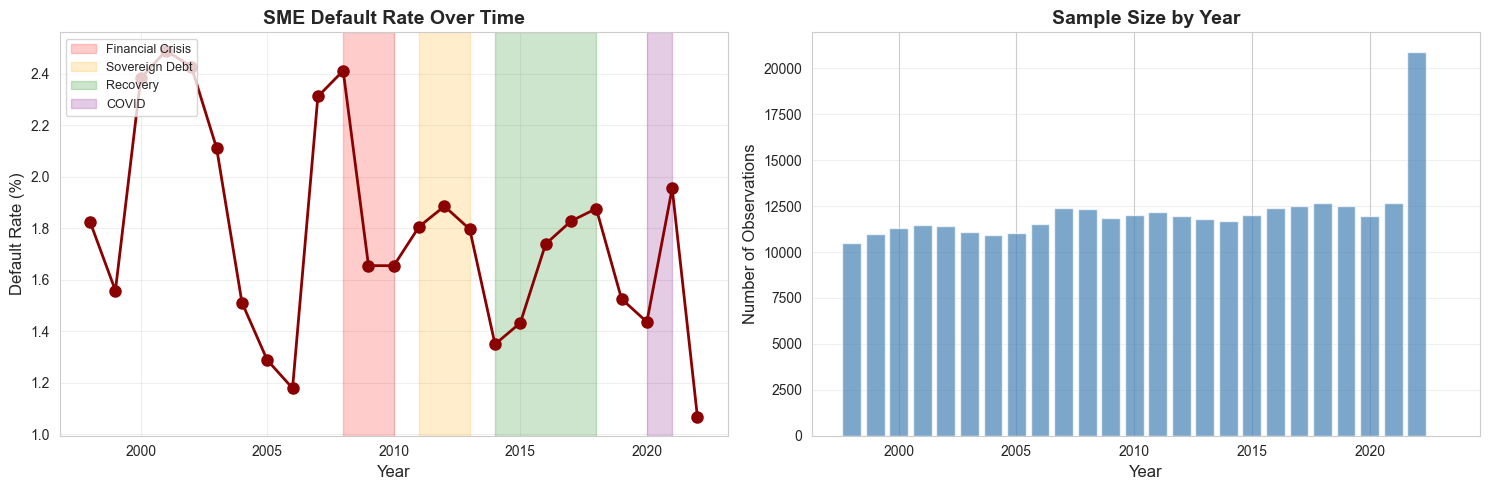


Note: Economic regimes used in temporal analysis:
  • Financial Crisis: 2008-2010
  • Sovereign Debt Crisis: 2011-2013
  • Recovery: 2014-2018
  • COVID: 2020-2021
  • Post-COVID: 2022-2023


In [9]:
# Visualize default rate over time
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Default rate trend
axes[0].plot(default_rate_by_year['ser_year'], 
             default_rate_by_year['default_rate']*100, 
             marker='o', linewidth=2, markersize=8, color='darkred')
axes[0].set_xlabel('Year', fontsize=12)
axes[0].set_ylabel('Default Rate (%)', fontsize=12)
axes[0].set_title('SME Default Rate Over Time', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Add regime annotations
axes[0].axvspan(2008, 2010, alpha=0.2, color='red', label='Financial Crisis')
axes[0].axvspan(2011, 2013, alpha=0.2, color='orange', label='Sovereign Debt')
axes[0].axvspan(2014, 2018, alpha=0.2, color='green', label='Recovery')
axes[0].axvspan(2020, 2021, alpha=0.2, color='purple', label='COVID')
axes[0].legend(fontsize=9, loc='upper left')

# Sample size over time
axes[1].bar(default_rate_by_year['ser_year'], 
            default_rate_by_year['n_total'], 
            color='steelblue', alpha=0.7)
axes[1].set_xlabel('Year', fontsize=12)
axes[1].set_ylabel('Number of Observations', fontsize=12)
axes[1].set_title('Sample Size by Year', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nNote: Economic regimes used in temporal analysis:")
print("  • Financial Crisis: 2008-2010")
print("  • Sovereign Debt Crisis: 2011-2013")
print("  • Recovery: 2014-2018")
print("  • COVID: 2020-2021")
print("  • Post-COVID: 2022-2023")

## 2.1 Feature Means by Bankruptcy Status

Comparison of average feature values for companies that defaulted vs those that did not.

In [11]:
# Compare means for bankruptcy vs non-bankruptcy cases
# Select only numeric columns
X_numeric = X.select_dtypes(include=[np.number])

X_with_target = X_numeric.copy()
X_with_target['target'] = y.values

# Calculate means by group
means_no_default = X_with_target[X_with_target['target'] == 0].drop(columns=['target']).mean()
means_default = X_with_target[X_with_target['target'] == 1].drop(columns=['target']).mean()

# Create comparison table
comparison_df = pd.DataFrame({
    'Feature': means_no_default.index,
    'Mean (No Default)': means_no_default.values,
    'Mean (Default)': means_default.values,
    'Difference': means_default.values - means_no_default.values,
    'Pct Difference (%)': ((means_default.values - means_no_default.values) / np.abs(means_no_default.values) * 100)
})

# Sort by absolute percentage difference to show most distinguishing features
comparison_df['Abs Pct Diff'] = np.abs(comparison_df['Pct Difference (%)'])
comparison_df = comparison_df.sort_values('Abs Pct Diff', ascending=False).drop(columns=['Abs Pct Diff'])

print("="*100)
print("FEATURE MEANS: BANKRUPTCY vs NON-BANKRUPTCY")
print("="*100)
print(f"\nNon-default observations: {(y==0).sum():,}")
print(f"Default observations: {(y==1).sum():,}")
print("\n" + comparison_df.to_string(index=False))

FEATURE MEANS: BANKRUPTCY vs NON-BANKRUPTCY

Non-default observations: 298,795
Default observations: 5,354

                       Feature  Mean (No Default)  Mean (Default)  Difference  Pct Difference (%)
                   ny_avkegkap              0.029       -1.590694   -1.619695        -5585.087828
             ny_solid_yoy_diff           0.008616       -0.044205   -0.052822         -613.043631
                  ny_nettomarg          -0.928262       -4.498717   -3.570455         -384.638779
  ratio_cash_liquidity_yoy_abs           0.065957       -0.139419   -0.205375         -311.378678
                   ny_skuldgrd           6.710536       21.565964   14.855428          221.374682
       inventory_days_yoy_diff          -43.17503     -111.040215  -67.865185         -157.186191
                    ny_kapomsh            2.90765        7.178332    4.270682          146.877436
               revenue_cagr_3y           0.210032        0.465349    0.255317          121.561184
          

## 3. Feature Distributions

Summary statistics and distributions for key features.

In [12]:
# Descriptive statistics for all features
feature_stats = X.describe().T
# Only calculate missing % for columns in feature_stats (numeric columns)
missing_pct = X[feature_stats.index].isnull().sum() / len(X) * 100
feature_stats['missing_%'] = missing_pct.values
feature_stats['dtype'] = X[feature_stats.index].dtypes.values

print("="*80)
print("FEATURE SUMMARY STATISTICS (Top 20 by std dev)")
print("="*80)
print(feature_stats.sort_values('std', ascending=False).head(20).to_string())

# Save full stats for appendix
output_dir = PROJ_ROOT / "results" / "data_exploration"
output_dir.mkdir(parents=True, exist_ok=True)
feature_stats.to_csv(output_dir / "feature_statistics.csv")
print(f"\n✓ Full feature statistics saved to: {output_dir / 'feature_statistics.csv'}")

FEATURE SUMMARY STATISTICS (Top 20 by std dev)
                                   count         mean           std           min         25%        50%        75%            max  missing_%    dtype
ny_omspanst                     302187.0  2279.866699  12819.611328           0.0       686.0     1070.0     1790.0      2254791.0   0.645079  float32
dso_days                        303648.0   137.862259  10602.883789     -268.5849   30.137192  51.227978  72.732391      4720545.0   0.164722  float32
inventory_days_yoy_diff         268702.0   -44.420437   6420.641602  -1971269.375   -1.360045        0.0    1.03868  125625.507812  11.654485  float32
ny_foradlvpanst                 302194.0   603.038635   3620.091553      -71376.0       356.0      476.0      640.0      1602064.0   0.642777  float32
dpo_days                        286893.0    63.338249   3165.312744   -212.269485   21.094879  34.483795  51.202541      1547600.0   5.673535  float32
ratio_cash_interest_cov         282805.0  -359.

In [13]:
# Missing data pattern
missing_data = pd.DataFrame({
    'feature': X.columns,
    'missing_count': X.isnull().sum().values,
    'missing_pct': (X.isnull().sum() / len(X) * 100).values
}).sort_values('missing_pct', ascending=False)

features_with_missing = missing_data[missing_data['missing_pct'] > 0]

if len(features_with_missing) > 0:
    print("\n" + "="*80)
    print(f"MISSING DATA SUMMARY ({len(features_with_missing)} features with missing values)")
    print("="*80)
    print(features_with_missing.to_string(index=False))
else:
    print("\n✓ No missing data in features")


MISSING DATA SUMMARY (25 features with missing values)
                       feature  missing_count  missing_pct
                profit_cagr_3y         124802    41.033178
           revenue_drawdown_5y          82059    26.979868
                   term_spread          77596    25.512496
               revenue_cagr_3y          64357    21.159695
       inventory_days_yoy_diff          35447    11.654485
             ny_solid_yoy_diff          33097    10.881838
       ratio_cash_interest_cov          21344     7.017613
                       ny_omsf          20516     6.745378
  ratio_cash_liquidity_yoy_abs          19514     6.415934
                      dpo_days          17256     5.673535
                   ny_avkegkap          12487     4.105554
                   ny_skuldgrd          12484     4.104567
                      ny_solid          12484     4.104567
                 log_br10_eksu          12421     4.083854
                   ny_omspanst           1962     0.645079


In [14]:
# Select all numeric features for visualization
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"Total numeric features: {len(numeric_features)}")
print(f"Visualizing distributions for all {len(numeric_features)} numeric features")

Total numeric features: 27
Visualizing distributions for all 27 numeric features


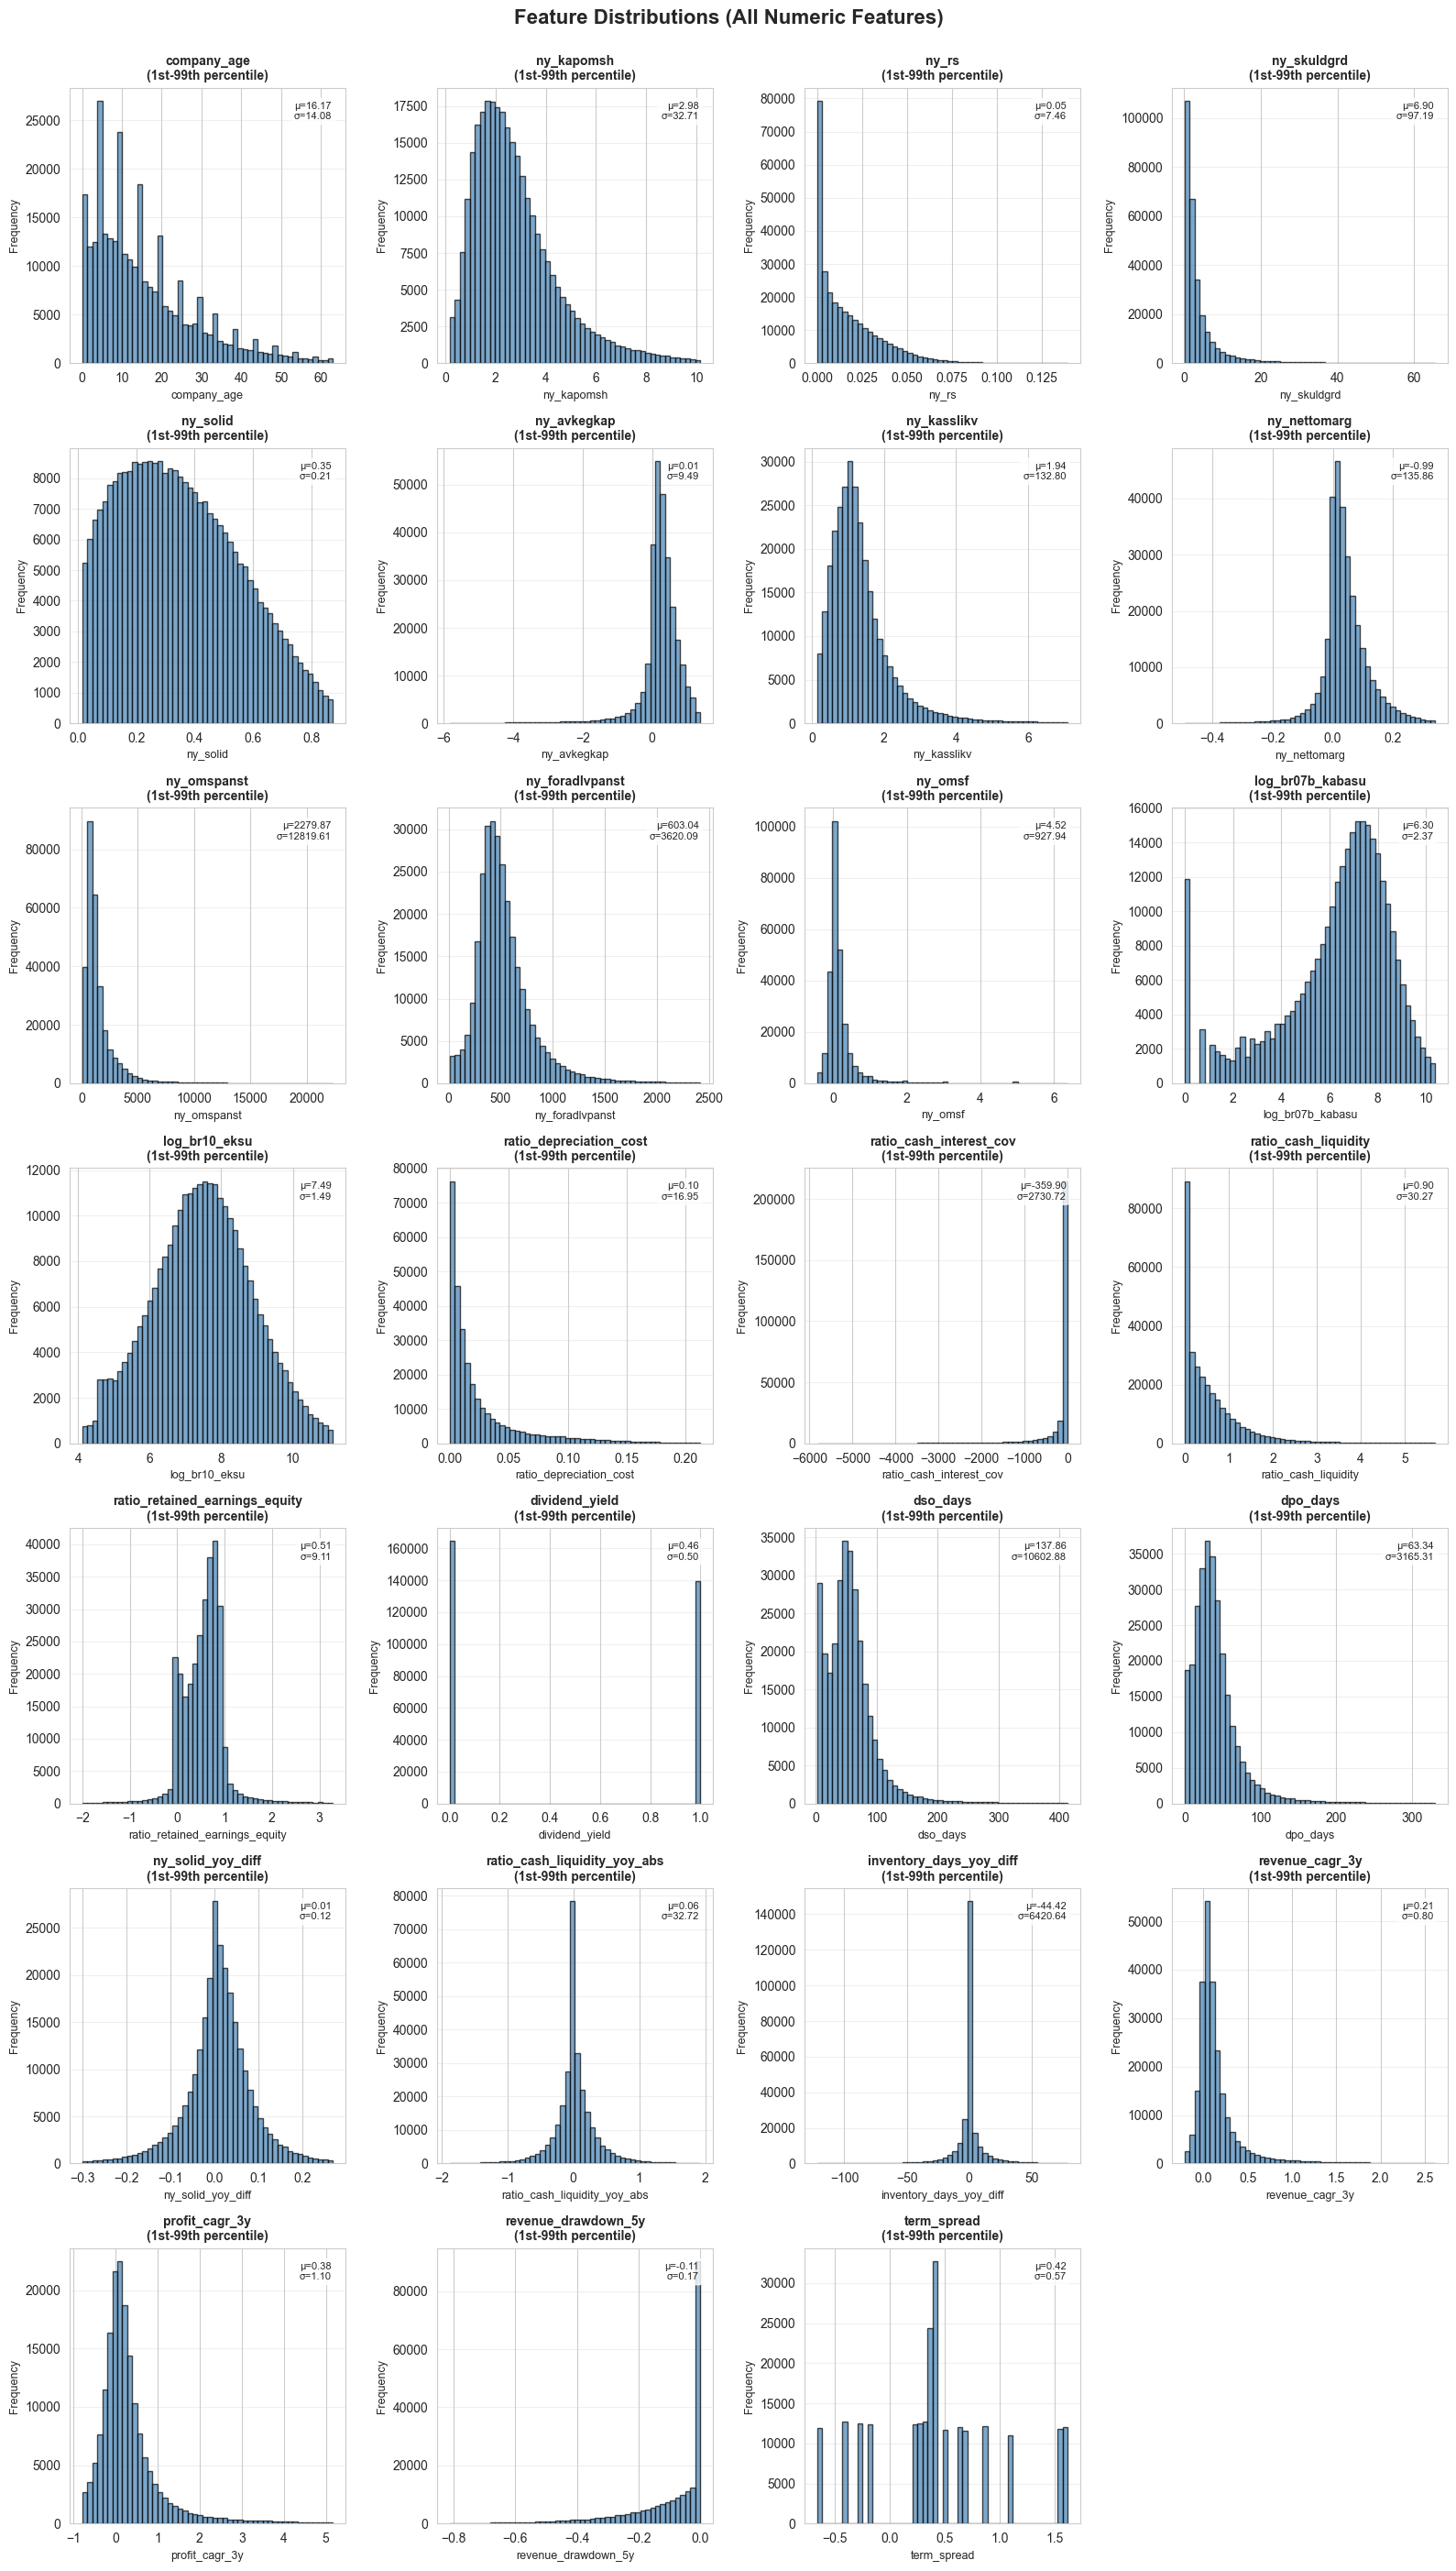

In [15]:
# Histograms for all numeric features
n_features = len(numeric_features)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()

for idx, feature in enumerate(numeric_features):
    ax = axes[idx]
    
    # Remove extreme outliers for visualization (1st-99th percentile)
    data = X[feature].dropna()
    if len(data) > 0:
        p1, p99 = data.quantile([0.01, 0.99])
        data_clipped = data[(data >= p1) & (data <= p99)]
        
        ax.hist(data_clipped, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
        ax.set_xlabel(feature, fontsize=9)
        ax.set_ylabel('Frequency', fontsize=9)
        ax.set_title(f'{feature}\n(1st-99th percentile)', fontsize=10, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        # Add summary stats
        stats_text = f"μ={data.mean():.2f}\nσ={data.std():.2f}"
        ax.text(0.95, 0.95, stats_text, transform=ax.transAxes,
                fontsize=8, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    else:
        ax.text(0.5, 0.5, 'No data', transform=ax.transAxes,
                ha='center', va='center', fontsize=12)

# Hide unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Feature Distributions (All Numeric Features)', 
             fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()

## 4. Feature Correlations

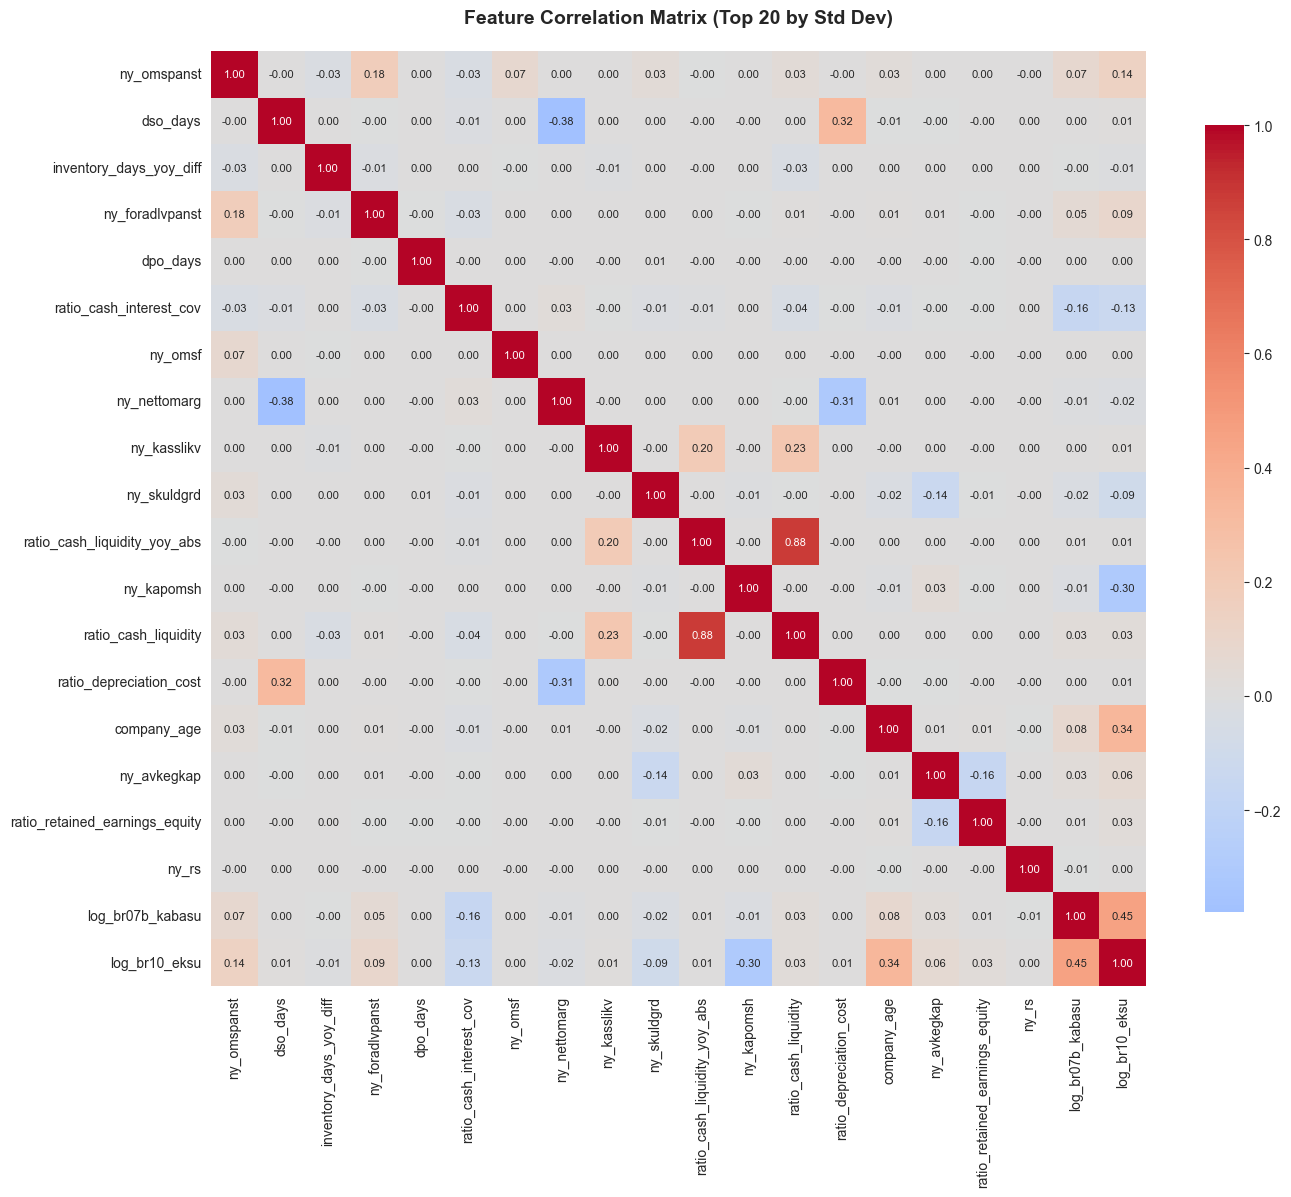


Analyzing correlations across all numeric features...

Highly Correlated Feature Pairs (|r| > 0.7): 1 pairs found
           feature_1                    feature_2  correlation
ratio_cash_liquidity ratio_cash_liquidity_yoy_abs      0.87598


In [16]:
# Correlation matrix for all numeric features
# For readability, limit to top 20 most variable features
top_20_features = feature_stats.sort_values('std', ascending=False).head(20).index.tolist()
corr_matrix = X[top_20_features].corr()

fig, ax = plt.subplots(1, 1, figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, ax=ax, cbar_kws={'shrink': 0.8},
            annot_kws={'fontsize': 8})
ax.set_title('Feature Correlation Matrix (Top 20 by Std Dev)', 
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Find highly correlated pairs across ALL numeric features
print("\nAnalyzing correlations across all numeric features...")
full_corr_matrix = X[numeric_features].corr()
high_corr = []
for i in range(len(full_corr_matrix.columns)):
    for j in range(i+1, len(full_corr_matrix.columns)):
        if abs(full_corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append({
                'feature_1': full_corr_matrix.columns[i],
                'feature_2': full_corr_matrix.columns[j],
                'correlation': full_corr_matrix.iloc[i, j]
            })

if high_corr:
    print(f"\nHighly Correlated Feature Pairs (|r| > 0.7): {len(high_corr)} pairs found")
    print("="*80)
    high_corr_df = pd.DataFrame(high_corr).sort_values('correlation', ascending=False, key=abs)
    print(high_corr_df.to_string(index=False))
else:
    print("\n✓ No highly correlated feature pairs (|r| > 0.7) among all numeric features")

## 5. Company Size Distribution

SME SIZE DISTRIBUTION
sme_category  n_companies  n_defaults  default_rate
       Micro            0           0          <NA>
       Small       287975        5130      0.017814
      Medium        16174         224      0.013849
       Large            0           0          <NA>
     Unknown            0           0          <NA>


/var/folders/5c/7nyvkw450d38pmzqgbgq75wc0000gn/T/ipykernel_16837/3591146831.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sme_dist = df_with_target.groupby('sme_category').agg({


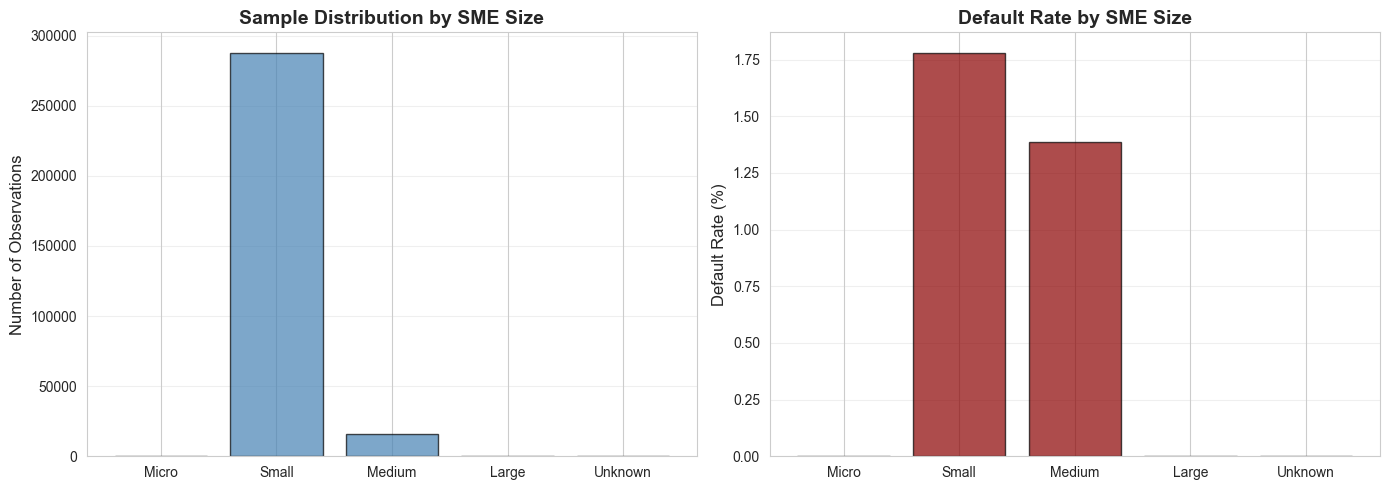

In [17]:
# SME category distribution
sme_dist = df_with_target.groupby('sme_category').agg({
    'target_next_year': ['count', 'sum', 'mean']
}).reset_index()
sme_dist.columns = ['sme_category', 'n_companies', 'n_defaults', 'default_rate']

print("="*80)
print("SME SIZE DISTRIBUTION")
print("="*80)
print(sme_dist.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sample distribution
axes[0].bar(sme_dist['sme_category'], sme_dist['n_companies'], 
            color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Number of Observations', fontsize=12)
axes[0].set_title('Sample Distribution by SME Size', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Default rate by size - convert to float to handle NA values
default_rate_values = pd.to_numeric(sme_dist['default_rate'], errors='coerce').fillna(0) * 100
axes[1].bar(sme_dist['sme_category'], default_rate_values,
            color='darkred', alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Default Rate (%)', fontsize=12)
axes[1].set_title('Default Rate by SME Size', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Industry Distribution

TOP 10 INDUSTRIES BY SAMPLE SIZE
industry  n_companies  n_defaults  default_rate
     494        19101         378       0.01979
     561        17389         355      0.020415
     471        16088          93      0.005781
     432        14994         275      0.018341
     412        13007         425      0.032675
     433        11629         315      0.027087
     812        10235         183       0.01788
     431         7921         170      0.021462
     439         7919         188       0.02374
     711         7870         116       0.01474


/var/folders/5c/7nyvkw450d38pmzqgbgq75wc0000gn/T/ipykernel_16837/2679130628.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  industry_dist = df_with_target.groupby('sni_group_3digit').agg({


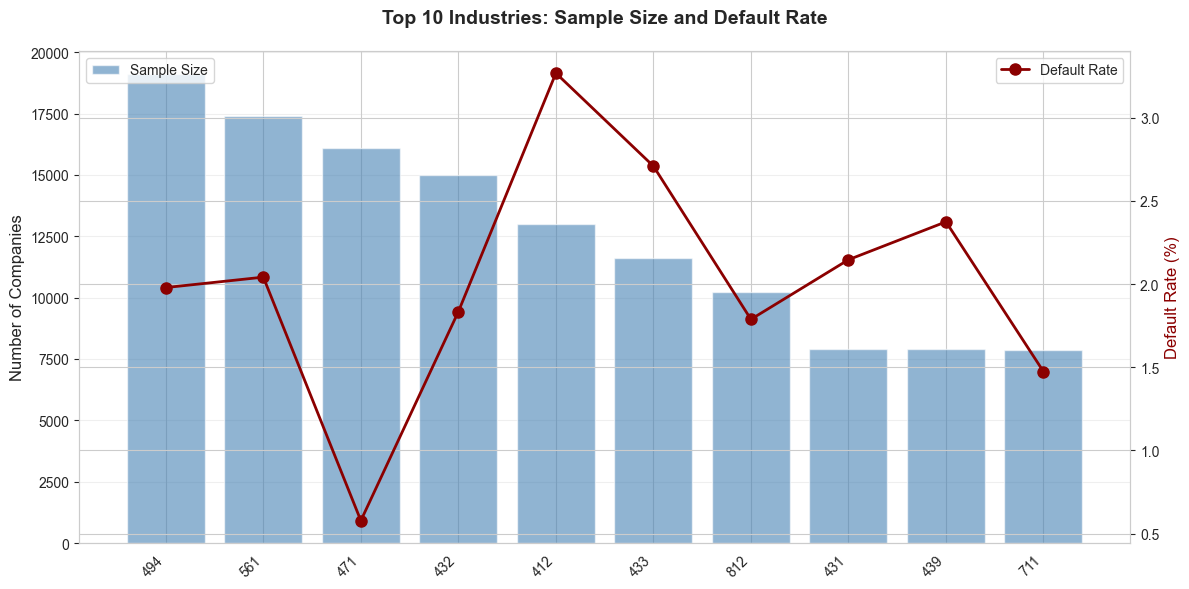

In [18]:
# Top 10 industries by sample size
if 'sni_group_3digit' in df_with_target.columns:
    industry_dist = df_with_target.groupby('sni_group_3digit').agg({
        'target_next_year': ['count', 'sum', 'mean']
    }).reset_index()
    industry_dist.columns = ['industry', 'n_companies', 'n_defaults', 'default_rate']
    industry_dist = industry_dist.sort_values('n_companies', ascending=False).head(10)
    
    print("="*80)
    print("TOP 10 INDUSTRIES BY SAMPLE SIZE")
    print("="*80)
    print(industry_dist.to_string(index=False))
    
    # Visualization
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    # Dual axis: sample size (bars) and default rate (line)
    ax2 = ax.twinx()
    
    x_pos = np.arange(len(industry_dist))
    ax.bar(x_pos, industry_dist['n_companies'], 
           color='steelblue', alpha=0.6, label='Sample Size')
    ax2.plot(x_pos, industry_dist['default_rate']*100, 
             color='darkred', marker='o', linewidth=2, markersize=8, label='Default Rate')
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(industry_dist['industry'], rotation=45, ha='right')
    ax.set_ylabel('Number of Companies', fontsize=12)
    ax2.set_ylabel('Default Rate (%)', fontsize=12, color='darkred')
    ax.set_title('Top 10 Industries: Sample Size and Default Rate', 
                 fontsize=14, fontweight='bold', pad=20)
    
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Industry information not available in dataset")

## 7. Summary for Thesis Appendix

In [19]:
# Create comprehensive summary table
summary = {
    'Metric': [
        'Total Observations',
        'Number of Features',
        'Time Period',
        'Default Rate (%)',
        'Imbalance Ratio',
        'Small SMEs (%)',
        'Medium SMEs (%)',
        'Features with Missing Data',
        'Avg Missing Rate (%)'
    ],
    'Value': [
        f"{len(X):,}",
        f"{X.shape[1]}",
        f"{df['ser_year'].min()}-{df['ser_year'].max()}",
        f"{y.mean()*100:.2f}",
        f"{(y==0).sum()/(y==1).sum():.1f}:1",
        f"{(df['sme_category']=='Small').mean()*100:.1f}",
        f"{(df['sme_category']=='Medium').mean()*100:.1f}",
        f"{len(features_with_missing) if len(features_with_missing) > 0 else 0}",
        f"{missing_data['missing_pct'].mean():.2f}" if len(features_with_missing) > 0 else "0.00"
    ]
}

summary_df = pd.DataFrame(summary)

print("\n" + "="*80)
print("DATASET SUMMARY FOR THESIS APPENDIX")
print("="*80)
print(summary_df.to_string(index=False))

# Save to CSV
summary_df.to_csv(output_dir / "dataset_summary.csv", index=False)
print(f"\n✓ Dataset summary saved to: {output_dir / 'dataset_summary.csv'}")

print("\n" + "="*80)
print("DATA EXPLORATION COMPLETE")
print("="*80)
print(f"\nOutputs saved to: {output_dir}")
print("  - feature_statistics.csv: Full feature summary statistics")
print("  - dataset_summary.csv: High-level dataset summary")
print("\nAll figures in this notebook are suitable for thesis appendix.")


DATASET SUMMARY FOR THESIS APPENDIX
                    Metric     Value
        Total Observations   304,149
        Number of Features        29
               Time Period 1998-2023
          Default Rate (%)      1.76
           Imbalance Ratio    55.8:1
            Small SMEs (%)      94.1
           Medium SMEs (%)       5.9
Features with Missing Data        25
      Avg Missing Rate (%)      6.26

✓ Dataset summary saved to: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/results/data_exploration/dataset_summary.csv

DATA EXPLORATION COMPLETE

Outputs saved to: /Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/results/data_exploration
  - feature_statistics.csv: Full feature summary statistics
  - dataset_summary.csv: High-level dataset summary

All figures in this notebook are suitable for thesis appendix.
